# Making a Feedforward Neural Network from scratch (Optional)
We will try to make a feedforward neural network from scratch. This is an optional assignment. If you are even a little bit familiar with neural networks, know what neurons, weights, biases, feed-forward network, back propagration, gradient descent, activation functions are, then you can start right away. If not, don't worry. You can take a look at this medium article: https://medium.com/@waadlingaadil/learn-to-build-a-neural-network-from-scratch-yes-really-cac4ca457efc and try to learn what all these terms/topics are. Just knowing what they are won't help. I would recommend you to do the math along with the reading (because math is awesome!). Also avoid using for loops in this whole assignment. Now let's start!!

First, import the most important library required for machine learning (Tensorflow? Pytorch? No. We are not going to use premade models, so these libraries are not required). Guess the short form for the library too :)

In [109]:
## Import the library
import numpy as np

Now the neural network is for some dataset, right? We will use the MNIST dataset. It consists of 60k training images and 10k test images of size 28 $\times$ 28 with some digit written on each image. Our goal is to make a neural network which can identify the digit written on the image. Loading the dataset is done for you in the next block. Do not change anything in the block

In [110]:
### DO NOT MODIFY THIS BLOCK
### This block has the class for loading the MNIST dataset

import struct
from array import array
from os.path import join
import matplotlib.pyplot as plt
import random

class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)
    
def show_images(images, title_texts):
    cols = 3
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(20,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

training_images_filepath = "mnist_dataset/train-images.idx3-ubyte"
training_labels_filepath = "mnist_dataset/train-labels.idx1-ubyte"
test_images_filepath = "mnist_dataset/t10k-images.idx3-ubyte"
test_labels_filepath = "mnist_dataset/t10k-labels.idx1-ubyte"

In [111]:
## DO NOT MODIFY THIS BLOCK
## This block loads the MNIST dataset
## Just run this block once

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

x_train and x_test have the images in list form, and y_train and y_test have the labels of the images stored as a list. You can try printing the values in these variables to see what shape they have.

In [112]:
# TASK: find out the shapes of all these lists and print them
# TODO
x_train=np.array(x_train)
print(x_train.shape)
y_train=np.array(y_train)
print(y_train.shape)
x_test=np.array(x_test)
print(x_test.shape)
y_test=np.array(y_test)
print(y_test.shape)
# END TODO

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


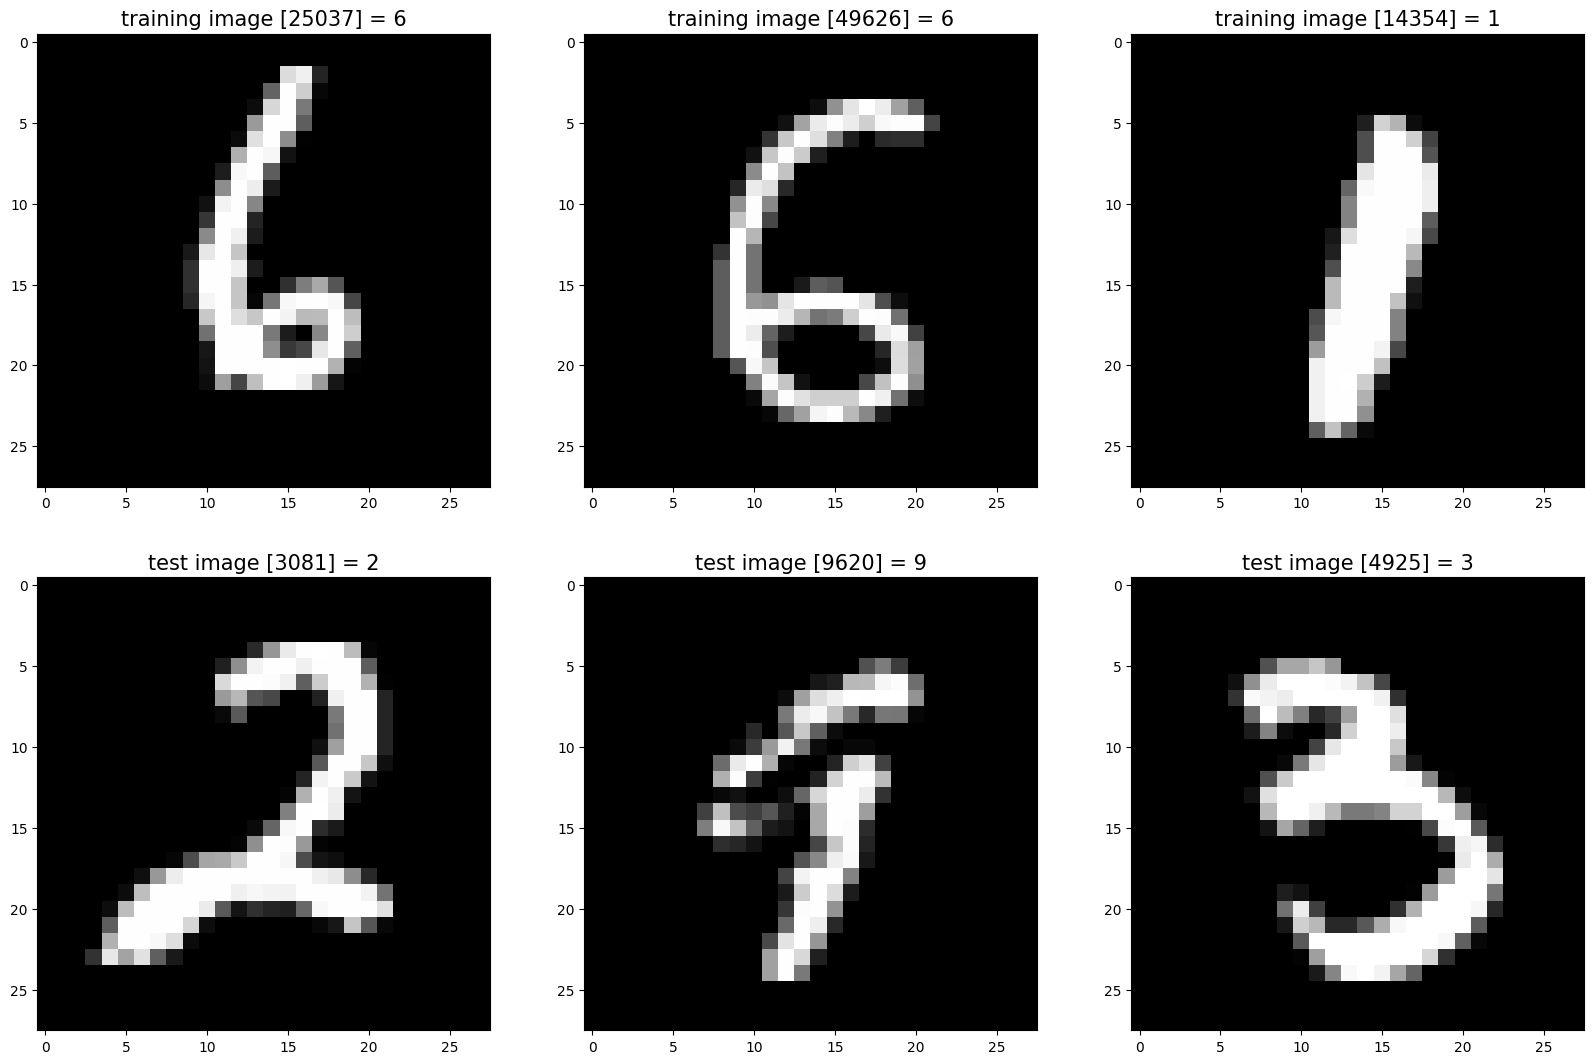

In [113]:
## You always need to check how your data looks like, right?
## Run this block to see the some random 3 training and test images
## Change the variable number_of_images_to_show as per your requirement

images_2_show = []
titles_2_show = []
number_of_images_to_show = 3
# 3 random training images
for i in range(0, number_of_images_to_show):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

# 3 random test images
for i in range(0, number_of_images_to_show):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

## Data Preprocessing
Data preprocessing is a very important step in data analysis. It includes cleaning, integration, transformation, reduction, discretization and normalization of the given dataset. Outlier analysis is also an important step in preprocessing. Here, the data is clean (our work has been reduced).<br><br>
We will only scale the data. If you try printing the images e.g. <code>print(x_train[0])</code>, you will find that the values in the list lie between 0 to 255. Scale these down to 0 to 1. Also convert the images x_train, x_test from list to numpy array. Also flatten this array to a shape (x_train.shape[0], __, 1) to make each image in it compatible with the input layer of our neural network.

Realize that after flattening the image, it went from size of 28x28(2 dimensional) to a size of 784 (1 dimensional). We flatten the image so that we can feed these pixel values into the feed forward neural network. 

In [114]:
def preprocess(x_train, x_test):
    # <START>
    # Convert the data to numpy arrays
    # already done when tring to find shape
    # Scale the data to the range of 0-1
    x_train=(x_train-x_train.min())/(x_train.max()-x_train.min())
    x_test=(x_test-x_test.min())/(x_test.max() - x_test.min())
    x_train=x_train.reshape(x_train.shape[0],784,1)
    x_test=x_test.reshape(x_test.shape[0],784,1)
    # <END>
    return x_train, x_test

x_train, x_test = preprocess(x_train, x_test)

One hot encoding is a method of representing the labels. You can read about it here: https://www.geeksforgeeks.org/ml-one-hot-encoding/ . We will convert y_train and y_test to numpy arrays and then one-hot encode them + reshape them to a matrix instead of a vector.

Make sure that you appreciate the reason for one-hot encoding the labels.

#### Hint:
<details> You can use the function np.eye() for one-hot encoding </details>

In [115]:
def one_hot(y_train, y_test):
  # <Start>
  # Convert to numpy arrays
    # done already 
  # Apply one-hot encoding
    # One -hot encoding helps in labelling and here since we have 10 categories digits 0-9 we represent that number by a 1 i its place
    # using numbers like 1,2,3 etc for labelling may make the model believe that it is the weights of the labels etc so to avoid that we use
    # 0 and 1 
    # also, in the cost function cross-entropy loss, the cost simplifies to C=-log(y(predicted or correct digit)) which basically pushes up 
    # its probability and reduces the probability of others
    while y_train.ndim > 1:
      y_train = np.argmax(y_train, axis=-1) # reverting multiple one-hot encodings basically I run this block multiple times so the encoding became like (60000,10,10,10)
    while y_test.ndim > 1:
      y_train = np.argmax(y_test, axis=-1)
    print(y_train.shape)
    print(y_test.shape)
    y_train=y_train.astype(int)
    y_test=y_test.astype(int)
    print(y_train.dtype)
    y_train=np.eye(10)[y_train]
    y_test=np.eye(10)[y_test]
    assert y_train.shape == (60000,10)
    assert y_test.shape == (10000,10) # assert to catch the previous errors quickly
    print(y_train.shape)
    print(y_test.shape)
  # Reshape the data
  
  # <End>
    return y_train, y_test

y_train, y_test = one_hot(y_train, y_test)

(60000,)
(10000,)
int64
(60000, 10)
(10000, 10)


## Building the neural network

We will make a neural network with 4 layers of neurons (1 input layer, 2 hidden layers, 1 output layer). The size of the layers (number of neurons in them) would be (784, 128, 32, __). Guess the final layers size and make a tuple n with these values.

Note that the choice of neurons in the hidden layers i.e. 128 and 32 in hidden layer 1 and 2 respectively is subjective here. However, you would always what to decrease the number of neurons in subsequent layers (make sure you understand why?)

In [116]:
# we want to decrease number of nodes in subsequent layers because we want the model to focus on some specific features as it goes to the 
# deeper layers
# also most pixels in our dataset are background and useless so reducing the nodes help in removing noise and discarding useless variations
# this also reduces the number of parameters and reduces training time while does not affect functionality
n = (784, 128, 32, 10) # Replace None with the correct values 
epochs = 20 # Replace None with the correct values. Keep the epochs low (1-3) while testing the code. Once you are confident that the code is working fine, you can set the epochs to 10-20. This is just to save time.
lr = 0.01 # This is the learning rate. Keep it in the range of 0.001 to 0.1

The class NN, short for neural network :/, is made in the next block. The train function already completed. First look at the training loop to understand the flow and inputs to various functions in this neural network. Then complete the functions.

In [117]:
from tqdm import tqdm

class NN:
    def __init__(self, n, epochs, lr):
        self.n = n # tuple specifing the number of neurons in each layer the 2 hidden layer arcitecture.
        self.epochs = epochs
        self.lr = lr

        self.input_layer = n[0]
        self.hidden_layer1 = n[1]
        self.hidden_layer2 = n[2]
        self.output_layer = n[3]

        # Make a dictionary self.params to store the weights and biases 
        # The keys will be W1, W2, W3, b1, b2, b3
        # Figure out the shapes of these weights and biases vectors
        # Initialize the weights and biases with random values (using a suitable numpy function ofcourse)
        self.params = { 
            # <START>
            'W1':np.random.randn(n[1],n[0]),
            'W2':np.random.randn(n[2],n[1]),
            'W3':np.random.randn(n[3],n[2]),
            'b1':np.random.randn(n[1],1), 
            'b2':np.random.randn(n[2],1),
            'b3':np.random.randn(n[3],1),
            # <END>
        }

    # In a neural network, we need an activation function.
    # You can read about activation functions here: https://www.geeksforgeeks.org/activation-functions-neural-networks/
    # Here, we will use the sigmoid function
    def sigmoid(self, x, derivative=False) :
        sig=1/(1+np.exp(-x))
        sigx=sig*(1-sig)
        if (derivative):
            return sigx # Dummy return
        return sig # Dummy return
    
    # We will also use the softmax function (we will use this in our final layer)
    # You can read about the softmax function here: https://www.geeksforgeeks.org/the-role-of-softmax-in-neural-networks-detailed-explanation-and-applications/
    def softmax(self, x, derivative=False):
        e_x = np.exp(x - np.max(x)) # Why x - np.max(x)? The values in the array e_x will now be in the range 0 to 1.
        z=e_x / np.sum(e_x,axis=0,keepdims=True)
        if derivative:
            return z*(1-z) # Dummy return
        return z # Dummy return

    # Feed forward the image through the network i.e. do forward propogation
    def feed_forward(self, image):
        params = self.params
        W1 = self.params['W1']
        W2 = self.params['W2']
        W3 = self.params['W3']
        b1= self.params['b1']
        b2= self.params['b2']
        b3= self.params['b3']
        params['a0'] = image

        # <START>
        params['z1'] = W1 @ image +b1 # z1 = W1@image + b1
        params['a1'] = self.sigmoid(params['z1'],False) # Applly the sigmoid activation function

        params['z2'] = W2 @ params['a1'] +b2 # z2 = W2@image + b2
        params['a2'] = self.sigmoid(params['z2'],False) # Apply the sigmoid activation function 
        
        params['z3'] = W3 @ params['a2'] # z3 = W3@image + b3
        params['a3'] = self.softmax(params['z3'],False) # Apply sofmax activation function (since this is the final layer)
        #<END>

        return params['a3']

    # Loss for the prediction of label for one image
    # Use Mean Squared Error loss
    def loss(self, output_label, true_label):
        m=output_label.shape[0]
        losses=((true_label-output_label)**2)
        aver=np.sum(losses)/m
        return aver # Dummy return
    
    # Back propagation is the process of updating the weights of the neural network to minimize the loss (the very step that makes the neural network learn)
    # You can read about back propagation here: https://www.geeksforgeeks.org/backpropagation-in-neural-network/
    def back_propagation(self, output, y_true):
        params = self.params
        A0 = params['a0']
        A1 = params['a1']
        A2 = params['a2']
        A3 = params['a3']
        y_true=y_true.reshape(-1,1) # do this because y_true was (10,) so numpy was broadcasting the dC_dZ3 to (10,10) and then matrix multiplication was causing errors
        W1 = self.params['W1']
        W2 = self.params['W2']
        W3 = self.params['W3']
        change_w = {}
        change_b = {}
        m=output.shape[0]
        # <START> This one is going to be difficult unless you know the maths.
        dC_dZ3=(2*(A3-y_true)*(self.softmax(A3,True)))/m
        change_w['W3'] = dC_dZ3 @ (A2.T)  # Dummy value
        change_b['b3'] = np.sum(dC_dZ3,axis=1,keepdims=True) # Dummy value
        dC_dA2=(W3.T) @ (dC_dZ3)

        dC_dZ2=dC_dA2 * (self.sigmoid(A2,True))
        change_w['W2'] = dC_dZ2 @ (A1.T) # Dummy value
        change_b['b2'] = np.sum(dC_dZ2,axis=1,keepdims=True) # Dummy value
        dC_dA1=(W2.T) @ (dC_dZ2)

        dC_dZ1=dC_dA1 *(self.sigmoid(A1,True))
        change_w['W1'] = dC_dZ1 @ (A0.T) # Dummy value
        change_b['b1'] = np.sum(dC_dZ1,axis=1,keepdims=True) # Dummy value
        # <END>

        return change_w, change_b
    
    # We just recorded what the change in weights and biases should be. Now, we will actually update the weights and biases (using Gradient Descent)
    def update_weights(self, change_w, change_b):
        params = self.params
        # <START>
        params['W3'] = params['W3'] - self.lr * (change_w['W3'])
        params['b3'] = params['b3'] - self.lr * (change_b['b3'])

        params['W2'] = params['W2'] - self.lr * (change_w['W2'])
        params['b2'] = params['b2'] - self.lr * (change_b['b2'])

        params['W1'] = params['W1'] - self.lr * (change_w['W1'])
        params['b1'] = params['b1'] - self.lr * (change_b['b1'])
        # <END>

    # Training the neural network
    # We will feed forward the image, back propagate and update the weights and biases. This will be done for each image for the number of epochs specified.
    # The only place where you can use for loops
    def train(self, x_train, y_train) -> None:
        for i in range(self.epochs):
            for image, label in tqdm(zip(x_train, y_train), total=len(x_train), desc=f'Epoch {i+1}/{self.epochs}'):
                pred = self.feed_forward(image)
                change_w, change_b = self.back_propagation(pred, label)
                self.update_weights(change_w, change_b)

    # Predict the label for each image and store them in an array. This array will be used to calculate the accuracy of the model
    # You can use for loops here too :P
    def predict(self, x_test):
        predictions = np.array([])
        for image in x_test:
            pred = self.feed_forward(image)
            pred = np.argmax(pred)
            predictions = np.append(predictions, pred)

        return predictions
    
    # What's accuracy? Number of correct predictions / total number of predictions
    def accuracy(self, y_test, y_pred):
        count = 0
        y_true = y_test.reshape(y_test.shape[0], -1)
        y_true = np.argmax(y_true, axis=1)
        for i in range(len(y_true)):
            if y_true[i] == y_pred[i]:
                count += 1
        return count / len(y_true)

Can you point out the limitations of the above implementation? 
<details> It only works for a 2 hidden layer neural network </details>

Task:
Play around with the number of the number of neurons in the hidden layer, number of epochs and the learning rate and observe how these HYPERPARAMETERS affect the outcomes.

In [118]:
nn = NN(n, epochs, lr)

In [119]:
nn.train(x_train, y_train)

Epoch 20/20: 100%|██████████| 60000/60000 [00:51<00:00, 1174.89it/s]


In [120]:
y_pred = nn.predict(x_test)

In [121]:
print(nn.accuracy(y_test, y_pred)*100)

78.03999999999999
